# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pickle
import itertools
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

# b. MNIST Data Loader

In [77]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
		transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Unconditional GAN**


# a. Training Function for Discriminator

In [28]:
criterion = nn.BCELoss()

def train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels):
    discriminator.zero_grad()
    if with_condition:
      outputs = discriminator(images, cls_labels)
    else:
      outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.view(-1, 1))
    real_score = outputs

    if with_condition:
      outputs = discriminator(fake_images, cls_labels)
    else:
      outputs = discriminator(fake_images)

    fake_loss = criterion(outputs, fake_labels.view(-1, 1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score, fake_loss

# b. Training Function for Generator

In [66]:
def train_generator(generator, g_optimizer, discriminator_outputs, real_labels, with_condition):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.view(-1, 1))
    g_loss_fake = criterion(discriminator_outputs, 1 - real_labels.view(-1, 1))
    g_loss.backward()
    g_optimizer.step()
    return g_loss, g_loss_fake

# c. Monitors for Images and Losses


In [30]:
def monitor_images(generator, test_noise, with_condition):
    num_test_samples = test_noise.shape[0]
    size_figure_grid = int(math.sqrt(num_test_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)

    if with_condition:
      cls_labels = torch.randint(0, 10, (num_test_samples,)).to(device)
      test_images = generator(test_noise, label = cls_labels)
    else:
      test_images = generator(test_noise)

    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
        if with_condition:
            ax[i, j].set_title(f'Class: {cls_labels[k].item()}', fontsize=10)
    plt.show()


def monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake):
    def moving_average(x, win=100):
        return np.convolve(x, np.ones(win), 'same') / np.convolve(np.ones_like(x), np.ones(win), 'same')

    plt.figure(figsize=(10, 5))
    iters = np.arange(len(d_losses))
    epochs = iters * batch_size / 60000
    plt.plot(epochs, moving_average(d_losses), label='d_loss')
    plt.plot(epochs, moving_average(g_losses), label='g_loss')
    plt.plot(epochs, moving_average(d_losses_fake), label='d_loss_fake')
    plt.plot(epochs, moving_average(g_losses_fake), label='g_loss_fake')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


# c. Model for Discriminator

In [31]:
class Discriminator(nn.Module):
    def __init__(self, channels=[512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = None

        ##################
        ### Problem 1: Implement Discriminator
        ##################
        self.model = [
            nn.Linear(784, channels[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
        ]
        for i in range(len(channels) - 1):
            self.model += [
                nn.Linear(channels[i], channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout(0.2),
            ]
        self.model += [nn.Linear(channels[-1], 1), nn.Sigmoid()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out


with torch.no_grad():
    discriminator = Discriminator(with_condition=False).to(device)
    for iter, (images, labels) in enumerate(test_loader):
        images = images.to(device)  # (128, 1, 28, 8)
        labels = labels.to(device)  # (128,)
        print(discriminator(images, labels).shape)
        break

torch.Size([128, 1])


# e. Model for Generator


In [79]:
class Generator(nn.Module):
    def __init__(self, dim_z=100, channels=[128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = None
        ##################
        ### Problem 1: Implement Generator
        ##################
        self.model = [nn.Linear(dim_z, channels[0]), nn.LeakyReLU()]
        for i in range(len(channels) - 1):
            self.model += [nn.Linear(channels[i], channels[i + 1]), nn.LeakyReLU()]
        self.model += [nn.Linear(channels[-1], 784), nn.Tanh()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)

        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################

        out = self.model(x)
        return out


with torch.no_grad():
    generator = Generator(with_condition=False).to(device)
    noise = Variable(torch.randn(batch_size, generator.dim_z)).to(device)
    print(generator(noise).shape)

torch.Size([128, 784])


# d. Training

In [80]:
num_batches = len(train_loader)

def train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise,
                    num_epochs, d_freq, with_condition):
  d_losses = []
  g_losses = []
  d_losses_fake = []
  g_losses_fake = []
  dim_z = generator.dim_z
  for epoch in range(num_epochs):
      for n, (images, cls_labels) in enumerate(train_loader):
          images = Variable(images.to(device)) # (batch_size, 1, 28, 28)
          real_labels = Variable(torch.ones(images.size(0)).to(device)) # (batch_size, )
          cls_labels = cls_labels.to(device) # (batch_size, )

          # Sample from generator
          noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)
          fake_images = generator(noise, label=cls_labels if with_condition else None) # (batch_size, 784)
          fake_labels = Variable(torch.zeros(images.size(0)).to(device)) # (batch_size, )

          # Train the discriminator
          d_loss, real_score, fake_score, d_loss_fake = train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels=cls_labels)

          if n % d_freq == 0:
            # Sample again from the generator and get output from discriminator
            noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)

            for _ in range(10):
              fake_images = generator(noise, label=cls_labels if with_condition else None)
              outputs = discriminator(fake_images, label=cls_labels if with_condition else None)

              # Train the generator
              g_loss, g_loss_fake = train_generator(generator, g_optimizer, outputs, real_labels, with_condition)
              if (n+1) % 100 == 0:
                print(f'g_loss: {g_loss.data}')

          d_losses.append(d_loss.data.detach().cpu().numpy())
          g_losses.append(g_loss.data.detach().cpu().numpy())
          d_losses_fake.append(d_loss_fake.data.detach().cpu().numpy())
          g_losses_fake.append(g_loss_fake.data.detach().cpu().numpy())

          if (n+1) % 100 == 0:
              print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, d_loss_fake: %.4f, g_loss: %.4f, g_loss_fake: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data, d_loss_fake.data, g_loss.data, g_loss_fake.data,
                      real_score.data.mean(), fake_score.data.mean()))

      monitor_images(generator, test_noise, with_condition=with_condition)
      monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)
  return d_losses, d_losses_fake, g_losses, g_losses_fake

In [81]:
# set number of epochs and initialize figure counter
num_epochs = 1
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

epoch=20


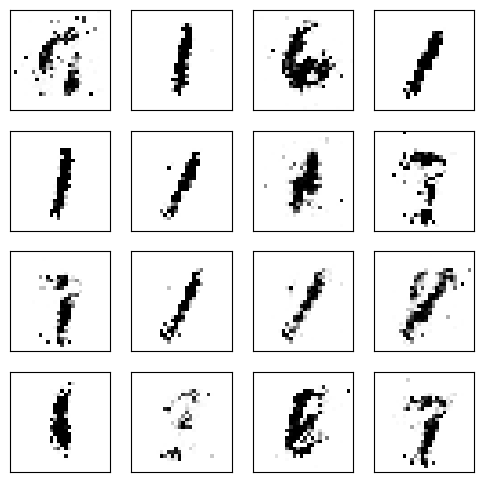

epoch=60


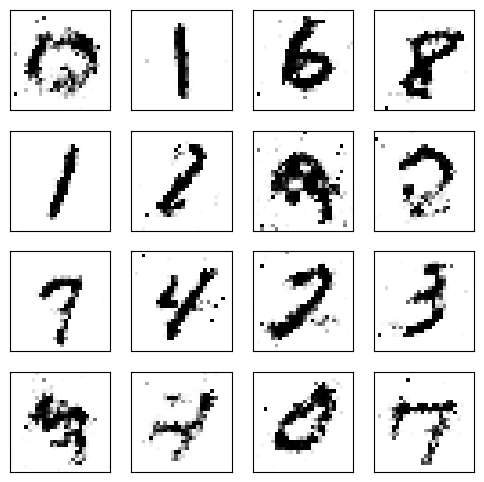

epoch=100


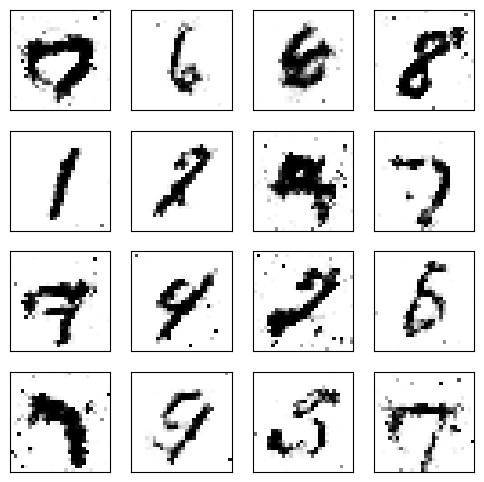

epoch=140


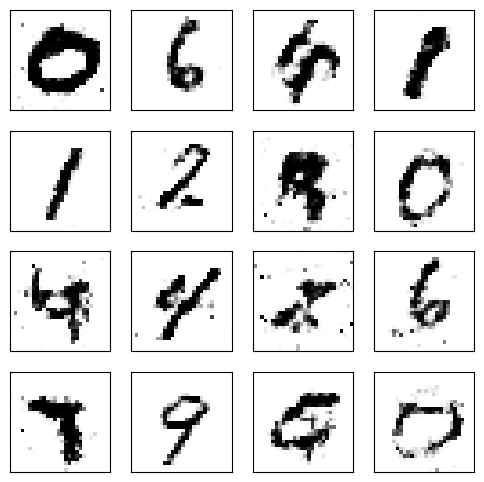

epoch=180


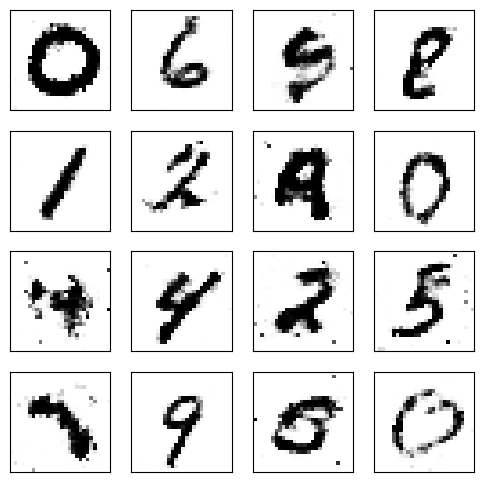

epoch=220


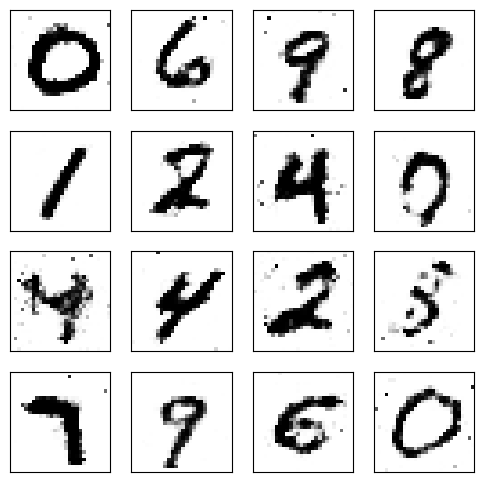

In [95]:
generator = Generator(with_condition=False).to(device)
for epoch in [20, 60, 100, 140, 180, 220]:
    generator.load_state_dict(torch.load(f"./models/GAN_gen_epoch={epoch}.pt"))
    print(f"epoch={epoch}")
    monitor_images(generator, test_noise, with_condition=generator.with_condition)

# e. Ablation Study

In [ ]:
##################
### Problem 2: Ablation study 1, 2, and 3
##################


# **2. Conditional GAN**

In [ ]:
num_epochs = 500
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = True

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)